In [1]:
from load_dataset import load_HELOC_dataset
from model_manager import PytorchModelManager
from cf_engine.engine import CFEnginePytorch
from cf_engine.counterfactual import CounterfactualExampleBySubset

In [2]:
import numpy as mp
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

In [3]:
dataset = load_HELOC_dataset()
mm = PytorchModelManager(dataset)
dm = mm.get_dir_manager()
try:
    mm.load_model()
except FileNotFoundError:
    mm.train()
    mm.save_model()
engine = CFEnginePytorch(mm, dataset)

/Users/chengfurui/Projects/counterfactuals/cf_ml/dataset.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[col] = (data_df[col] - minx)/(maxx-minx)


In [4]:
dataset.get_columns()

['ExternalRiskEstimate',
 'MSinceOldestTradeOpen',
 'MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'NumTrades60Ever2DerogPubRec',
 'NumTrades90Ever2DerogPubRec',
 'PercentTradesNeverDelq',
 'MSinceMostRecentDelq',
 'MaxDelq2PublicRecLast12M',
 'MaxDelqEver',
 'NumTotalTrades',
 'NumTradesOpeninLast12M',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NumInqLast6Mexcl7days',
 'NetFractionRevolvingBurden',
 'NetFractionInstallBurden',
 'NumRevolvingTradesWBalance',
 'NumInstallTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'PercentTradesWBalance',
 'RiskPerformance_Good',
 'RiskPerformance_Bad']

In [5]:
filters = [(f, 0, 1e4, False) for f in dataset.get_feature_names(preprocess=False)]
setting = {'index': 5, 'changeable_attribute': ['AverageMInFile', 'MSinceOldestTradeOpen'], 
           'filters': filters, 'cf_num': 24, 'desired_class': 'opposite', 'weight': 'mads'}
subset_cf = engine.generate_cfs_from_setting(setting, use_cache=False, batch_size=2, proximity_weight=0.01, diversity_weight=0,\
                                             loss_diff=1e-6, cache=False)

/Users/chengfurui/Projects/counterfactuals/env/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1/1]  Epoch-0, time cost: 0.565s, loss: 4.588, iteration: 656, validation rate: 1.000
Total time cost: 0.590, validation rate: 1.000, average distance: 6.355, average loss: 4.588


/Users/chengfurui/Projects/counterfactuals/cf_ml/dataset.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[target_col] = self.description[target_col]['category'][0]
/Users/chengfurui/Projects/counterfactuals/env/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/chengfurui/Projects/counterfactuals/env/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [6]:
# prediction results
valid_origin = subset_cf.get_instance()
df = pd.DataFrame()
extended_valid_origin = df.append([valid_origin]*12, ignore_index=True)
valid_cf = subset_cf.get_cf()
# data information
feature = dataset.get_feature_names(preprocess=False)
des = dataset.get_description()

# difference between cfs and original instances
diff = valid_cf.reset_index(drop=True)[feature] - \
    extended_valid_origin.reset_index(drop=True)[feature]
diff.index = valid_cf['OriginIndex']
normed_diff = diff.copy()
for f in feature:
    normed_diff[f] = diff[f] / (des[f]['max'] - des[f]['min'])

In [7]:
good_index = valid_origin[valid_origin['RiskPerformance'] == 'Good'].index
bad_index = valid_origin[valid_origin['RiskPerformance'] == 'Bad'].index
good_origin = valid_origin.loc[good_index, :]
bad_fc = valid_cf[valid_cf['OriginIndex'].isin(good_index)]

key_features = normed_diff.columns[normed_diff.abs().sum().argsort()[-2:][::-1]]

LinAlgError: singular matrix

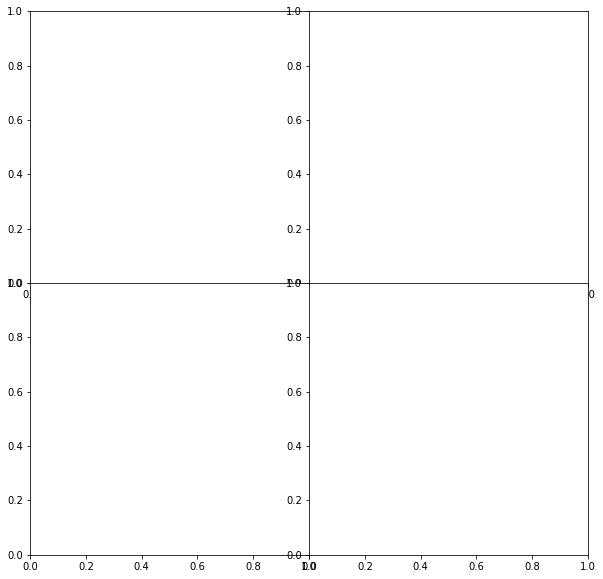

In [8]:
scatter_matrix(valid_cf[key_features], alpha=0.5, figsize=(10, 10), diagonal='kde')

In [ ]:
key_features

In [ ]:
valid_origin